In [1]:
import pandas as pd
Paris_1 = pd.read_csv('Coding_Paris_Week1.csv')
Paris_2 = pd.read_csv('Coding_Paris_Week2.csv')
Paris_3 = pd.read_csv('Coding_Paris_Week3.csv')
Paris_4 = pd.read_csv('Coding_Paris_Week4.csv')
Paris_5 = pd.read_csv('Coding_Paris_Week5.csv')
Shawn_1 = pd.read_csv('Coding_Shawn_Week1.csv')
Shawn_2 = pd.read_csv('Coding_Shawn_Week2.csv')
Shawn_3 = pd.read_csv('Coding_Shawn_Week3.csv')
Shawn_4 = pd.read_csv('Coding_Shawn_Week4.csv')
Shawn_5 = pd.read_csv('Coding_Shawn_Week5.csv')
Tianli_1 = pd.read_csv('Coding_Tianli_Week1.csv')
Tianli_2 = pd.read_csv('Coding_Tianli_Week2.csv')
Tianli_3 = pd.read_csv('Coding_Tianli_Week3.csv')
Tianli_4 = pd.read_csv('Coding_Tianli_Week4.csv')
Tianli_5 = pd.read_csv('Coding_Tianli_Week5.csv')
# Combine all the data frames into one
combined_df = pd.concat([
    Paris_1, Paris_2, Paris_3, Paris_4, Paris_5,
    Shawn_1, Shawn_2, Shawn_3, Shawn_4, Shawn_5,
    Tianli_1, Tianli_2, Tianli_3, Tianli_4, Tianli_5
], ignore_index=True)

combined_df['Sentiment'] = combined_df['Sentiment'].astype(int)

In [2]:
# Splitting the combined dataset into training and validation sets
train_df = combined_df.sample(frac=0.8, random_state=2024)

# Using the remaining 20% as validation data
validation_df = combined_df.drop(train_df.index)

In [3]:
train_df.groupby('Sentiment')['Tweet'].count() / len(train_df)

Sentiment
1    0.240044
2    0.093417
3    0.647008
4    0.019532
Name: Tweet, dtype: float64

In [4]:
# Define the mapping relationship
sentiment_map = {
    1: 'positive',
    2: 'negative',
    3: 'neutral',
    4: 'combination'
}

# Replace the numbers in the Sentiment column with the corresponding sentiment labels
train_df['Sentiment'] = train_df['Sentiment'].map(sentiment_map)

In [5]:
train_df

,Tweet,Sentiment
16487,'Cultured meat' could spell end of traditional...,positive
14558,Lab-grown meat is here – but will vegetarians ...,neutral
1756,RT @GoodFoodScience Did you miss last week's S...,neutral
7209,Home grown hamburgers? Ew!! - Is 'in vitro mea...,negative
317,"50 years from now, real meat will be a luxury ...",positive
...,...,...
5067,@Yea3601 @ItsMeChase1 @ShotgunWillard @unusual...,negative
878,"RT @NinesCatudio So, would you eat cultivated ...",neutral
9590,Finally a dream comes true: in-vitro-meat aka ...,positive
12755,Lab grown meat !!! Oh my its making my tummy t...,positive


In [6]:
import json

# Output file name
output_file = 'tweets_sentiment_finetune_1228_train.jsonl'

with open(output_file, mode='w', encoding='utf-8') as jsonl_file:
    for index, row in train_df.iterrows():
        json_record = {
            "messages": [
                {"role": "system", "content": "You are an expert in conducting sentiment analysis."},
                {"role": "user", "content": f"Evaluate the sentiment toward cultured meat that this tweet expresses: {row['Tweet']}.'\n'Return your response only as positive, negative, neutral, or combination."},
                {"role": "assistant", "content": row['Sentiment']}
            ]
        }
        jsonl_file.write(json.dumps(json_record) + '\n')

print(f"Conversion completed, JSONL file saved as {output_file}")

Conversion completed, JSONL file saved as tweets_sentiment_finetune_1228_train.jsonl


In [7]:
# Load the dataset
with open('tweets_sentiment_finetune_1228_train.jsonl', 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 18380
First example:
{'role': 'system', 'content': 'You are an expert in conducting sentiment analysis.'}
{'role': 'user', 'content': "Evaluate the sentiment toward cultured meat that this tweet expresses: 'Cultured meat' could spell end of traditional cattle farming within decades http://t.co/HXeXWmWodV via @ABCNews.'\n'Return your response only as positive, negative, neutral, or combination."}
{'role': 'assistant', 'content': 'positive'}


In [20]:
from collections import defaultdict

format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [8]:
from openai import OpenAI

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key="XXX", #hidden for privacy
)

client.files.create(
  file=open("tweets_sentiment_finetune_1228_train.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-E2i3fXr4NfTEYscxc3MESA', bytes=9083125, created_at=1735418136, filename='tweets_sentiment_finetune_1228_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [72]:
client.fine_tuning.jobs.create(
  training_file="file-WPecL3QCXZNv8n9699G4jzWW",
  model="gpt-4o-mini-2024-07-18"
)

FineTuningJob(id='ftjob-jp33fGvLC0cCFchw5AXaPwms', created_at=1728011462, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-jpYhTBnmIVRmvclaBivLf7aN', result_files=[], status='validating_files', trained_tokens=None, training_file='file-WPecL3QCXZNv8n9699G4jzWW', validation_file=None, user_provided_suffix=None, seed=1234073339, estimated_finish=None, integrations=[])

In [9]:
from openai import OpenAI

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key="XXX", #hidden for privacy
)

client.fine_tuning.jobs.retrieve("ftjob-No3ThSjF6lAmoiVjw7LLOfef")

FineTuningJob(id='ftjob-No3ThSjF6lAmoiVjw7LLOfef', created_at=1735426720, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-2024-08-06:personal:gpt-4o-finetuned-122824:Ajf3eJS1', finished_at=1735445948, hyperparameters=Hyperparameters(n_epochs=1, batch_size=12, learning_rate_multiplier=2), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-jpYhTBnmIVRmvclaBivLf7aN', result_files=['file-JR57ek7TmnYDNPh2tdFS23'], status='succeeded', trained_tokens=1709133, training_file='file-E2i3fXr4NfTEYscxc3MESA', validation_file=None, user_provided_suffix='GPT-4o-finetuned-122824', seed=555240845, estimated_finish=None, integrations=[], method={'type': 'supervised', 'supervised': {'hyperparameters': {'n_epochs': 1, 'batch_size': 12, 'learning_rate_multiplier': 2.0}}})

In [10]:
def answer(prompt):
    response = client.chat.completions.create(
        model="ft:gpt-4o-2024-08-06:personal:gpt-4o-finetuned-122824:Ajf3eJS1",
        messages=[
                {"role": "system", "content": "You are an expert in conducting sentiment analysis."},
                {"role": "user", "content":prompt} ],
        temperature = 0
    )
    return response.choices[0].message.content.strip()

In [11]:
def feed(i,df):
    text = (f"Evaluate the sentiment toward cultured meat that this tweet expresses: {df['Tweet'][i]}.'\n'Return your response only as positive, negative, neutral, or combination.")
    return text

In [12]:
validation_df = validation_df.reset_index(drop=True)

In [13]:
validation_df

,Tweet,Sentiment
0,@csimpsyo @Tbogin @jonlovett Cultured meat,3
1,RT @ndonyourtable What's the difference betwee...,3
2,#Technology #Tech Lab-Grown Meat Is Coming htt...,3
3,This year is the first time cultivated meat ha...,3
4,"RT @NewHarvestOrg 🍗and @UmaValeti, who co-foun...",3
...,...,...
4590,@Joseph_Plant What goes into lab grown meat? I...,2
4591,Google Funding Lab Grown Meat… No Animals Kill...,1
4592,RT @Orbyne #LSEForum cultured meat avoids the ...,1
4593,@MusadADroid @AuthorGusPegel The answer would ...,4


In [14]:
import time
sentiment = []
start = time.time()
count = 0
for i, v in validation_df.iterrows():
    sentiment.append(answer(feed(i,validation_df)))
    #time.sleep(15)
time_used = time.time()-start
#GPT-4o revised prompt

KeyboardInterrupt: 

In [14]:
time_used

2738.3514618873596

In [15]:
sentiment

['neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'combination',
 'combination',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'negative',
 'negative',
 'negative',
 'n

In [16]:
validation_df['GPT-4o_1'] = [i for i in sentiment]

In [17]:
# Define the mapping relationship
sentiment_map = {
     'positive': '1',
    'negative':'2',
    'neutral':'3',
    'combination': '4'
}

# Replace the numbers in the Sentiment column with the corresponding emotional labels
validation_df['GPT-4o_number_1'] = validation_df['GPT-4o_1'].map(sentiment_map).fillna(0).astype(int)

In [18]:
validation_df

,Tweet,Sentiment,GPT-4o_1,GPT-4o_number_1
0,@csimpsyo @Tbogin @jonlovett Cultured meat,3,neutral,3
1,RT @ndonyourtable What's the difference betwee...,3,neutral,3
2,#Technology #Tech Lab-Grown Meat Is Coming htt...,3,neutral,3
3,This year is the first time cultivated meat ha...,3,neutral,3
4,"RT @NewHarvestOrg 🍗and @UmaValeti, who co-foun...",3,neutral,3
...,...,...,...,...
4590,@Joseph_Plant What goes into lab grown meat? I...,2,negative,2
4591,Google Funding Lab Grown Meat… No Animals Kill...,1,positive,1
4592,RT @Orbyne #LSEForum cultured meat avoids the ...,1,positive,1
4593,@MusadADroid @AuthorGusPegel The answer would ...,4,positive,1


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(validation_df['Sentiment'], validation_df['GPT-4o_number_1'])
precision = precision_score(validation_df['Sentiment'], validation_df['GPT-4o_number_1'], average='weighted')
recall = recall_score(validation_df['Sentiment'], validation_df['GPT-4o_number_1'], average='weighted')
f1 = f1_score(validation_df['Sentiment'], validation_df['GPT-4o_number_1'], average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8248095756256801
Precision: 0.8291375140906608
Recall: 0.8248095756256801
F1 Score: 0.8261595680018685


In [11]:
validation_df.to_csv('GPT-4o_finetuned_1230.csv')

In [12]:
validation_df

,Tweet,Sentiment
10,@csimpsyo @Tbogin @jonlovett Cultured meat,3
13,RT @ndonyourtable What's the difference betwee...,3
14,#Technology #Tech Lab-Grown Meat Is Coming htt...,3
21,This year is the first time cultivated meat ha...,3
34,"RT @NewHarvestOrg 🍗and @UmaValeti, who co-foun...",3
...,...,...
22951,@Joseph_Plant What goes into lab grown meat? I...,2
22955,Google Funding Lab Grown Meat… No Animals Kill...,1
22958,RT @Orbyne #LSEForum cultured meat avoids the ...,1
22969,@MusadADroid @AuthorGusPegel The answer would ...,4


## Second Run

In [22]:
import time
sentiment = []
start = time.time()
count = 0
for i, v in validation_df.iterrows():
    sentiment.append(answer(feed(i,validation_df)))
    #time.sleep(15)
time_used = time.time()-start
#GPT-4o revised prompt

In [24]:
validation_df['GPT-4o_2'] = [i for i in sentiment]

# Define the mapping relationship
sentiment_map = {
     'positive': '1',
    'negative':'2',
    'neutral':'3',
    'combination': '4'
}

# Replace the numbers in the Sentiment column with the corresponding emotional labels
validation_df['GPT-4o_number_2'] = validation_df['GPT-4o_2'].map(sentiment_map).fillna(0).astype(int)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(validation_df['Sentiment'], validation_df['GPT-4o_number_2'])
precision = precision_score(validation_df['Sentiment'], validation_df['GPT-4o_number_2'], average='weighted')
recall = recall_score(validation_df['Sentiment'], validation_df['GPT-4o_number_2'], average='weighted')
f1 = f1_score(validation_df['Sentiment'], validation_df['GPT-4o_number_2'], average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8243743199129488
Precision: 0.8290931412379559
Recall: 0.8243743199129488
F1 Score: 0.8258608759181908


In [26]:
# Third run
import time
sentiment = []
start = time.time()
count = 0
for i, v in validation_df.iterrows():
    sentiment.append(answer(feed(i,validation_df)))
    #time.sleep(15)
time_used = time.time()-start
#GPT-4o revised prompt

In [29]:
validation_df['GPT-4o_3'] = [i for i in sentiment]

# Define the mapping relationship
sentiment_map = {
     'positive': '1',
    'negative':'2',
    'neutral':'3',
    'combination': '4'
}

# Replace the numbers in the Sentiment column with the corresponding emotional labels
validation_df['GPT-4o_number_3'] = validation_df['GPT-4o_3'].map(sentiment_map).fillna(0).astype(int)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(validation_df['Sentiment'], validation_df['GPT-4o_number_3'])
precision = precision_score(validation_df['Sentiment'], validation_df['GPT-4o_number_3'], average='weighted')
recall = recall_score(validation_df['Sentiment'], validation_df['GPT-4o_number_3'], average='weighted')
f1 = f1_score(validation_df['Sentiment'], validation_df['GPT-4o_number_3'], average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8232861806311208
Precision: 0.8278518023771495
Recall: 0.8232861806311208
F1 Score: 0.8246623011658326


In [31]:
#validation_df.to_csv('fine-tuned GPT-4o_20241230.csv')

In [15]:
import pandas as pd
validation_df = pd.read_csv('fine-tuned GPT-4o_20241230.csv')
validation_df

,Unnamed: 0,Tweet,Sentiment,GPT-4o_1,GPT-4o_number_1,GPT-4o_2,GPT-4o_number_2,GPT-4o_3,GPT-4o_number_3
0,0,@csimpsyo @Tbogin @jonlovett Cultured meat,3,neutral,3,neutral,3,neutral,3
1,1,RT @ndonyourtable What's the difference betwee...,3,neutral,3,neutral,3,neutral,3
2,2,#Technology #Tech Lab-Grown Meat Is Coming htt...,3,neutral,3,neutral,3,neutral,3
3,3,This year is the first time cultivated meat ha...,3,neutral,3,neutral,3,neutral,3
4,4,"RT @NewHarvestOrg 🍗and @UmaValeti, who co-foun...",3,neutral,3,neutral,3,neutral,3
...,...,...,...,...,...,...,...,...,...
4590,4590,@Joseph_Plant What goes into lab grown meat? I...,2,negative,2,negative,2,negative,2
4591,4591,Google Funding Lab Grown Meat… No Animals Kill...,1,positive,1,positive,1,positive,1
4592,4592,RT @Orbyne #LSEForum cultured meat avoids the ...,1,positive,1,positive,1,positive,1
4593,4593,@MusadADroid @AuthorGusPegel The answer would ...,4,positive,1,positive,1,positive,1


In [16]:
import krippendorff

import pandas as pd

# Select only the relevant columns for Krippendorff's alpha calculation
data = validation_df[['GPT-4o_number_1', 'GPT-4o_number_2', 'GPT-4o_number_3']].values.T

# Calculate Krippendorff's alpha
alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

print(f"Krippendorff's alpha: {alpha}")

Krippendorff's alpha: 0.9916063630519056


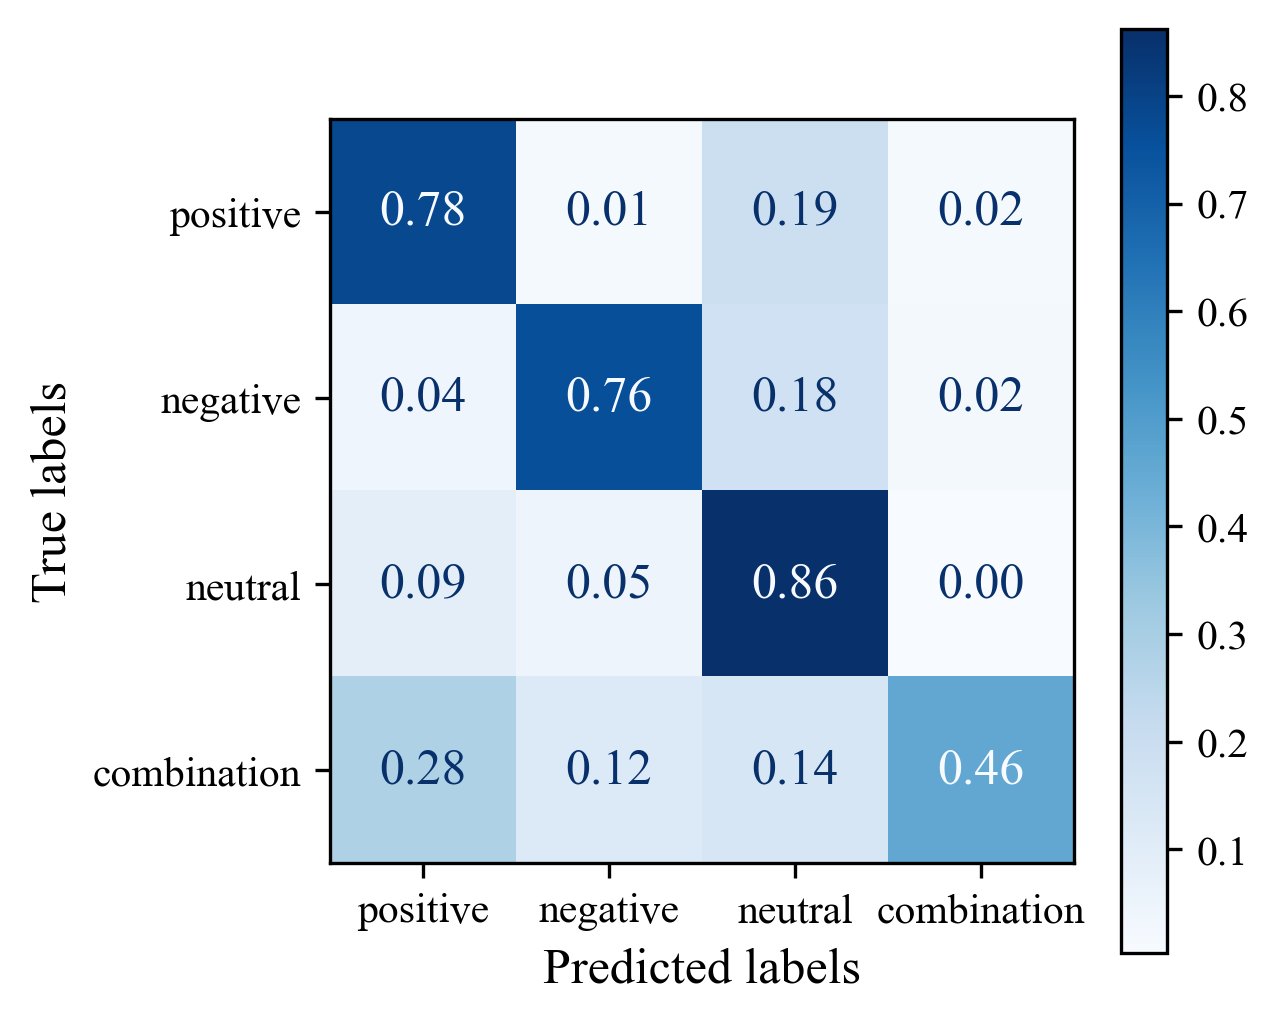

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Define a mapping of numeric labels to sentiment labels
label_mapping = {0: 'positive', 1: 'negative', 2: 'neutral', 3: 'combination'}
sentiment_labels = [label_mapping[i] for i in range(4)]  # List of sentiment labels in order

# Generate normalized confusion matrices for each run
conf_matrix1 = confusion_matrix(
    validation_df['Sentiment'], 
    validation_df['GPT-4o_number_1'], 
    normalize='true'
)
conf_matrix2 = confusion_matrix(
    validation_df['Sentiment'], 
    validation_df['GPT-4o_number_2'], 
    normalize='true'
)
conf_matrix3 = confusion_matrix(
    validation_df['Sentiment'], 
    validation_df['GPT-4o_number_3'], 
    normalize='true'
)

# Calculate the mean normalized confusion matrix
mean_conf_matrix = (conf_matrix1 + conf_matrix2 + conf_matrix3) / 3

# Create a ConfusionMatrixDisplay object for visualization, with customized labels
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=sentiment_labels)

# Plot the mean normalized confusion matrix
plt.rc('font', family='Times New Roman')  # Set the font to Times New Roman
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)  # Increase figure size and resolution
disp.plot(cmap='Blues', ax=ax, values_format=".2f")  # Format numbers as percentages with two decimals

# Customize the text size of numbers in the matrix
for text in disp.text_.ravel():
    text.set_fontsize(12)  # Increase font size of numbers in the matrix

# Set titles and labels with the desired font
plt.xlabel("Predicted labels", fontname='Times New Roman', fontsize=12)
plt.ylabel("True labels", fontname='Times New Roman', fontsize=12)
#plt.title("Mean Normalized Confusion Matrix Across 3 Runs", fontname='Times New Roman', fontsize=14)
plt.show()